In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import seaborn as sns
from sklearn.cluster import KMeans
from joblib import load
from sklearn.decomposition import PCA
import os.path
%matplotlib inline

### Loading the products data
This dataframe is the result of make_product_dataframe.py. The missing values 
were imputed with -1's, so they are new categories in the 'early_repayment' and
'penalty' columns

In [2]:
df = pd.read_csv('./result_files/products_dataframe.csv')

### Two columns with missing values: early_repayment and penalty
Contingency tables below show there may be a dependence of result on 
the missingness. The rows with missing values have a significantly lower
acceptance rate.

In [3]:
pd.concat([df.groupby('early_repayment')['result'].\
           value_counts(normalize=True).rename('values').reset_index().\
           pivot(index='result', columns='early_repayment', values='values').\
           rename(columns={-1:np.nan}), pd.DataFrame(df['early_repayment'].\
                                                     value_counts().\
        rename('total')).T.rename(columns={-1:np.nan})], axis=0)

,0.0,1.0,NaN
0,0.873016,0.794402,0.903406
1,0.126984,0.205598,0.096594
total,378.000000,96684.000000,45976.000000


In [4]:
pd.concat([df.groupby('penalty')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result',columns='penalty', 
        values='values').rename(columns={-1:np.nan}), 
        pd.DataFrame(df['penalty'].value_counts().rename('total')).T.\
           rename(columns={-1:np.nan})], axis=0)

,0.0,1.0,NaN
0,0.856266,0.781857,0.903158
1,0.143734,0.218143,0.096842
total,16301.000000,80383.000000,46354.000000


The following shows that the "counts" column is NOT the same as the "apply_num" column

In [5]:
print((df.apply_num == df.counts).sum(), (df.apply_num != df.counts).sum())

530 142508


### Look at results of random forest classifiers on "result"
This section uses the results of the classifier_gridsearches.py script. 
We look at the results of running a classifier using the "counts" column
and a classifier using the "apply_num" column

In [6]:
features_counts = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'result'], axis=1)

results = df['result']

In [7]:
best_est_counts = load('./result_files/randomforestclassifier_counts.joblib')
print(best_est_counts.score(features_counts, results))

0.9927921251695354


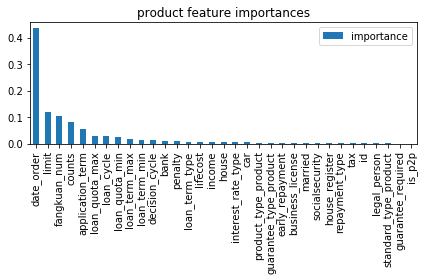

In [8]:
df_features_result_counts = pd.DataFrame(best_est_counts.feature_importances_, 
    index=features_counts.columns, columns=['importance'])
df_features_result_counts.sort_values(by='importance', ascending=False).plot.\
    bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [9]:
features_applynum = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'counts', 'result'], axis=1)

In [10]:
best_est_applynum = load('./result_files/randomforestclassifier_applynum.joblib')
print(best_est_applynum.score(features_applynum, results))

0.988953984255932


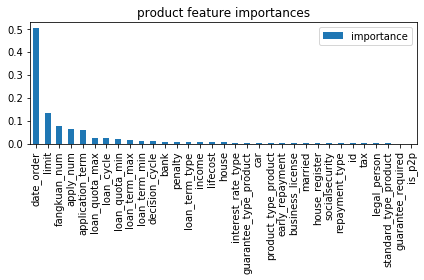

In [11]:
df_features_result_applynum = pd.DataFrame(best_est_applynum.\
                                           feature_importances_, index = 
                                           features_applynum.columns, 
                                           columns=['importance'])
df_features_result_applynum.sort_values(by='importance', ascending=False).\
    plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

Running the classifier using either the "counts" or the "applynum" column resulted in similar feature importances, and both "counts" and "apply_num" were 4th-most important in both instances
## Random Forest to determine number of applications
This section uses the results of the regressor_gridsearches.py script. We
look at the results of running regressors on the "counts" and "apply_num" columns

In [12]:
## for the features I drop the categorical variables that seem to hold limited info
features = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'counts'], axis=1)
counts_target = df['counts']
applynum_target = df['apply_num']

In [13]:
best_est_counts = load('./result_files/randomforestregressor_counts.joblib')
print(best_est_counts.score(features, counts_target))

0.8496590372565564


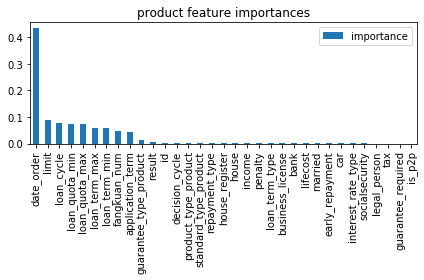

In [14]:
df_features_result_counts = pd.DataFrame(best_est_counts.feature_importances_, 
    index=features.columns, columns=['importance'])
df_features_result_counts.sort_values(by='importance', ascending=False).plot.\
    bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [15]:
best_est_applynum = load('./result_files/randomforestregressor_applynum.joblib')
print(best_est_applynum.score(features, applynum_target))

0.9999953458992898


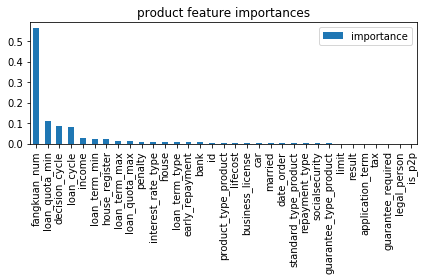

In [16]:
df_features_result_applynum = pd.DataFrame(best_est_applynum.\
                                           feature_importances_, index = 
                                           features.columns, 
                                           columns=['importance'])
df_features_result_applynum.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

These regressors have different feature importances, but they both place more importance on the continuous features.

### Clustering

Using the 15 most important features of the regressor on "counts" for kmeans-clustering

In [17]:
if os.path.isfile('./result_files/features_counts.csv'):
    features_counts = pd.read_csv('./result_files/features_counts.csv')
else:
    features_counts = df[df_features_result_counts.sort_values(by = 
                                                                "importance", 
                                                   ascending=False)[:15].\
                         index.tolist() + ['counts']]
    for column in features_counts.columns:
        if (features_counts[column].nunique() < 10) and \
            (features_counts[column].nunique() > 2):
            eatures_counts = pd.concat([features_counts, pd.get_dummies(
                features_counts[column], prefix=column)], axis=1)
    features_counts.to_csv('features_counts.csv', index=False)
                        
                        

In [18]:
## scaling the variables
counts_matrix = StandardScaler().fit_transform(features_counts.\
                    drop(['guarantee_type_product','product_type_product'], axis=1))

#### First do an elbow plot

In [19]:
kmeans = KMeans()

In [20]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

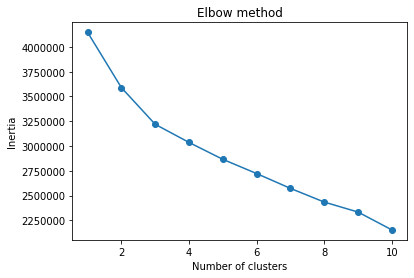

In [21]:
plot_inertia(kmeans, counts_matrix, range(1,11))

#### A bit of an elbow at k=3

In [22]:
kmeans3 = KMeans().set_params(n_clusters=3)

In [23]:
kmeans3.fit(counts_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [24]:
pd.Series(kmeans3.labels_).value_counts()

0    97634
1    29879
2    15525
dtype: int64

In [25]:
df['kmeans_group'] = kmeans3.labels_
df['Product Type'] = df['kmeans_group'].map({0:"Bronze", 1:"Gold", 2: "Silver"})
df.to_csv('./result_files/grouped_products.csv', index=False)

### Plot K-Means Results
Separate the continuous and categorical variables to make boxplots
and barplots, respectively

In [26]:
continuous_col = []
categorical_col = []
for column in df.columns:
    if column in ['bank_id','user_id','product_id', 'city_id_product']: continue
    if df[column].nunique() > 10:
        continuous_col.append(column)
    else: categorical_col.append(column)

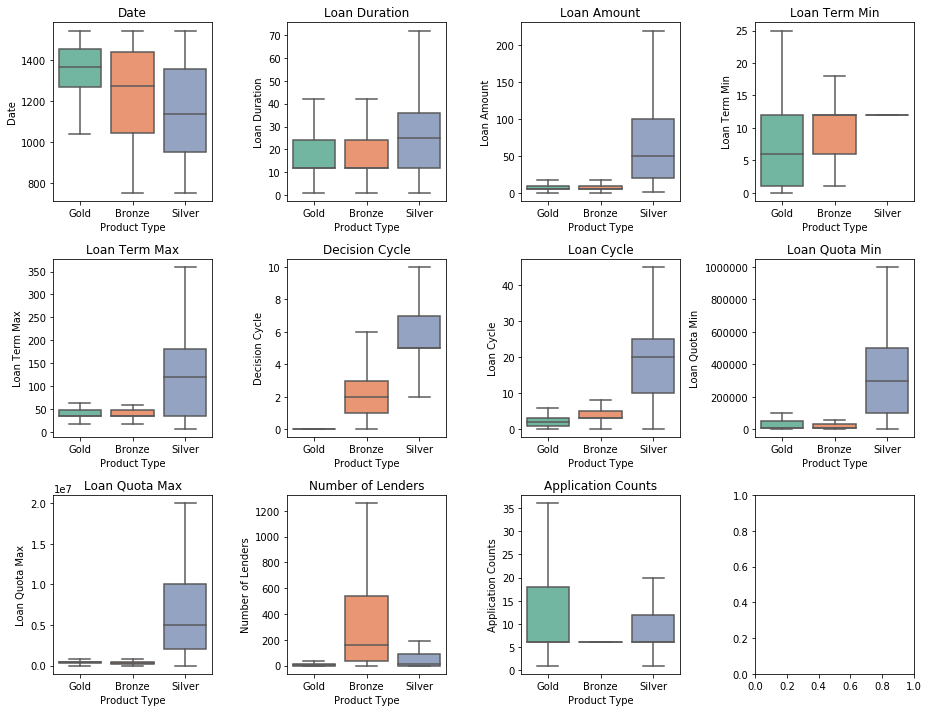

In [27]:
f, axes = plt.subplots(3,4, figsize=(13, 10))
i = 0
labels = ["Date", "Loan Duration", "Loan Amount", "Loan Term Min", "Loan Term Max",
          "Decision Cycle", "Loan Cycle", "Loan Quota Min", "Loan Quota Max", 
          "Number of Lenders", "Application Counts"]
for column in continuous_col:
    if column == 'apply_num': continue
    sns.boxplot(x='Product Type', y=column, data=df, palette='Set2',
                ax=axes[i//4][i%4], showfliers=False)
    axes[i//4][i%4].set_title(labels[i])
    axes[i//4][i%4].set_ylabel(labels[i])
    axes[i//4][i%4].set_ylabel(labels[i])
    i += 1
plt.tight_layout()

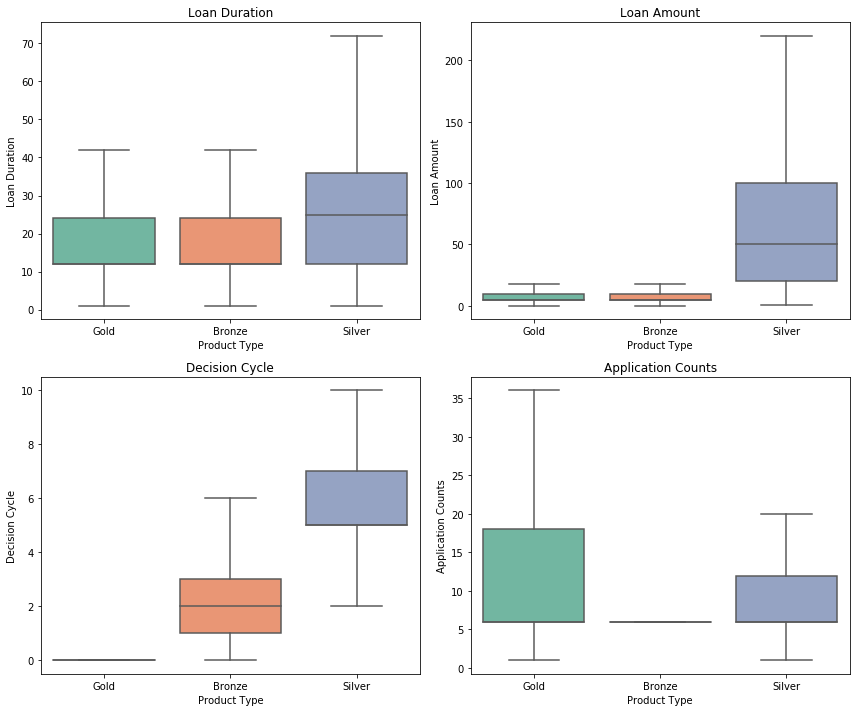

In [28]:
f, axes = plt.subplots(2,2, figsize=(12, 10))
labels = ["Loan Duration", "Loan Amount", "Decision Cycle", "Application Counts"]
for i, column in enumerate(['application_term','limit', 'decision_cycle', 'counts']):
    sns.boxplot(x='Product Type', y=column, data=df, palette='Set2',
                ax=axes[i//2][i%2], showfliers=False)
    axes[i//2][i%2].set_ylabel(labels[i])
    axes[i//2][i%2].set_title(labels[i])
plt.tight_layout()

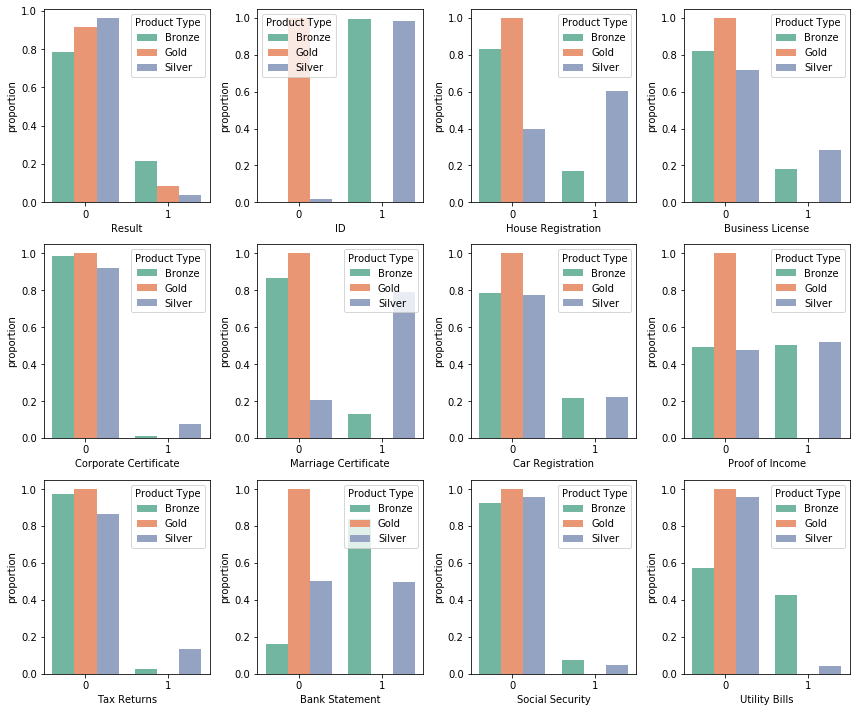

In [29]:
f, axes = plt.subplots(3,4, figsize=(12, 10))
labels = ['Result','ID','House Registration', 'Business License', 'Corporate Certificate', 
          'Marriage Certificate', 'Car Registration', 'Proof of Income', 'Tax Returns', 
          'Bank Statement', 'Social Security', 'Utility Bills']
for i, column in enumerate(['result','id','house_register', 'business_license',#'house',
                            'legal_person', 'married', 'car', 'income', 'tax', 'bank',#]):
                            'socialsecurity', 'lifecost']):
    plotdf = df.groupby('Product Type')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='Product Type', palette='Set2', data = plotdf, ax=axes[i//4][i%4])
    axes[i//4][i%4].set_xlabel(labels[i])
plt.tight_layout()

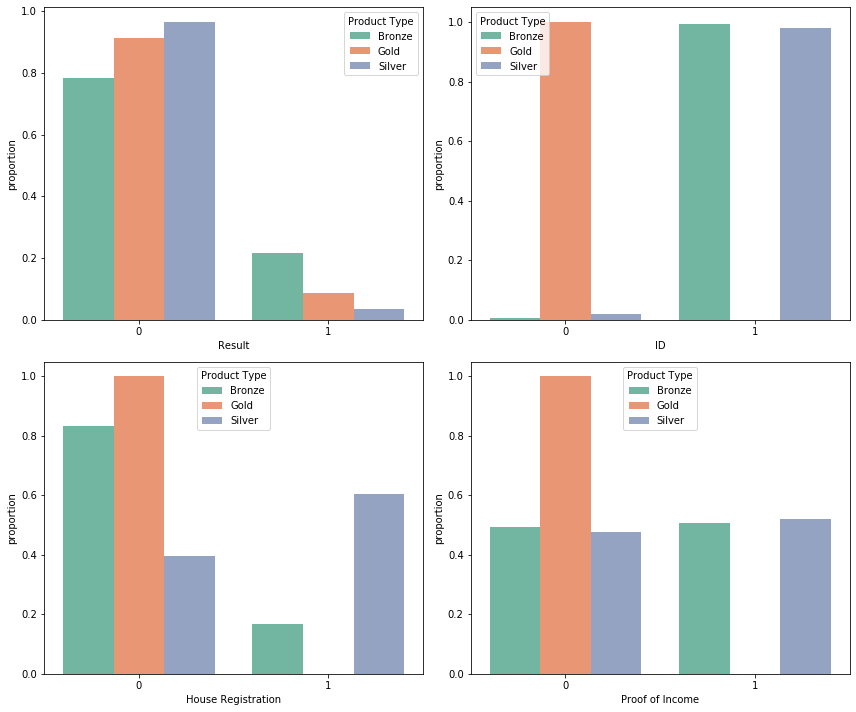

In [30]:
f, axes = plt.subplots(2,2, figsize=(12, 10))
labels = ['Result','ID','House Registration','Proof of Income'] #'Business License', 'Corporate Certificate', 
          #'Marriage Certificate', 'Car Registration', 'Proof of Income', 'Tax Returns', 
          #'Bank Statement', 'Social Security', 'Utility Bills']
for i, column in enumerate(['result','id','house_register', 'income']):
    plotdf = df.groupby('Product Type')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='Product Type', palette='Set2', data = plotdf, ax=axes[i//2][i%2])
    axes[i//2][i%2].set_xlabel(labels[i])
plt.tight_layout()

## PCA

In [31]:
# df = pd.read_csv('./result_files/grouped_products.csv')
## choose columns for PCA, then dummify and scale
df_pca = df.drop(['user_id', 'product_id', 'city_id_product', 'bank_id', 
                  'kmeans_group', 'Product Type'], axis=1)
for column in df_pca.columns:
    if (df_pca[column].nunique() < 10) and (df_pca[column].nunique() > 2):
        df_pca = pd.concat([df_pca.drop(column, axis=1), 
                            pd.get_dummies(df_pca[column], 
                                           prefix=column)], axis=1)
matrix_pca = StandardScaler().fit_transform(df_pca)

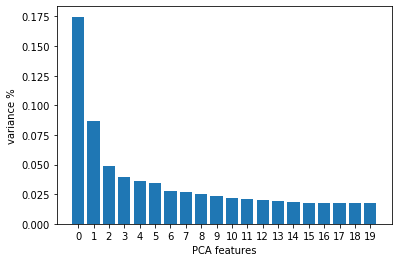

In [32]:
## find 20 Principle Components
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(matrix_pca)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

The first two principle components explain considerably more variance than the other ones
This is consistent with the k-means elbow plot

In [33]:
PCA_components['Product Type'] = df['Product Type']

Text(0, 0.5, 'PC 2')

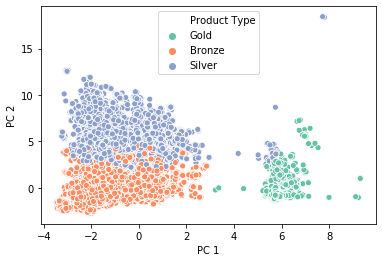

In [34]:
sns.scatterplot(x=0, y=1, hue='Product Type', style=None, 
                size=None, data=PCA_components, palette="Set2", hue_order=None, 
                hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                markers=True, style_order=None, x_bins=None, y_bins=None, units=None, 
                estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, 
                legend='brief', ax=None)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

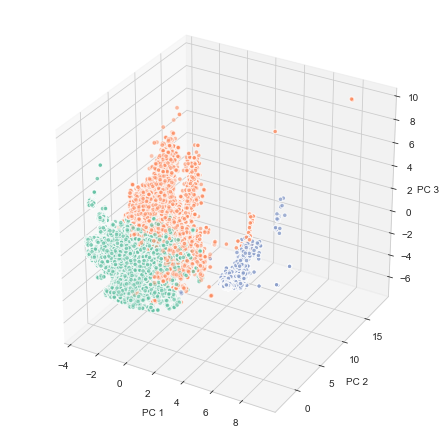

In [35]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = Axes3D(fig) 

#{0:"Bronze", 1:"Gold", 2: "Silver"}
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], c=df['kmeans_group'].map({0:plt.cm.Set2.colors[0], 1:plt.cm.Set2.colors[2], 2:plt.cm.Set2.colors[1]}), #PCA_components['Product Type'], 
           cmap=plt.cm.Set2, marker='o', edgecolors='white')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
#ax.
plt.show()